# Understanding activity and sleep patterns over time using time series analysis

## 1. Introduction

In this project I will be looking at data on activity and sleep to better understand how that varies over different periods, but also to try and focast how that may change in the future.

This study is quite unique among all my projects, in that the source of the data is me: my own activity and sleep! My general interest here is that I worry perhaps that my sleep has been getting worse over time, and also I am not sure if I am becoming less active. I would like to improve and increase both my activity levels and the amount of sleep I get. So I would like to better understand if these have really been getting worse over time, what exactly has been happening, and what is likely to happen in future.

So the specific questions I have for this study for both activity and sleep are:

- How have these been changing over time generally?
- What are the best and worst days of the week for these?
- Based on previous data, what is forcast for the future for these? and with how much confidence?

## 2. Methods for time series analysis

### 2.1 Classical methods

There are various classical approaches to time series analysis, which include:

- Autoregression (AR)
- Moving Average (MA)
- Autoregressive Moving Average (ARMA)
- Autoregressive Integrated Moving Average (ARIMA)
- Seasonal Autoregressive Integrated Moving-Average (SARIMA)
- Seasonal Autoregressive Integrated Moving-Average with Exogenous Regressors (SARIMAX)
- Vector Autoregression (VAR)
- Vector Autoregression Moving-Average (VARMA)
- Vector Autoregression Moving-Average with Exogenous Regressors (VARMAX)
- Simple Exponential Smoothing (SES)
- Holt Winter’s Exponential Smoothing (HWES)

Generally these fall into two categories: time domain or frequency domain approaches. Time domain approaches model future values based on past and present values. Frequency domain approaches model future values based on the idea that they can be seen as a function of time using sin and cosine graphs, which are known as Fourier representations. 

So Frequency domain models use regressions on sines and cosines, rather than past and present values as do Time domain models, to model the behavior of the data.

### 2.2 Facebook Prophet

[Prophet](https://facebook.github.io/prophet/) is an open source library for time series forcasting released in 2017 by Facebook.

Despite the availability of these classical approaches for time series analysis & forcasting, there are many challenges in applying these in practice - which are summarised in the [introductory paper](https://peerj.com/preprints/3190/) for Facebook Prophet:

>*Producing high quality forecasts is not an easy problem for either machines or for most analysts. We have observed two main themes in the practice of creating business forecasts:*
>
>*1. Completely automatic forecasting techniques can be brittle and they are often too inflexible to incorporate useful assumptions or heuristics.*
>
>*2. Analysts who can produce high quality forecasts are quite rare because forecasting is a specialized data science skill requiring substantial experience. The result of these themes is that the demand for high quality forecasts often far outstrips the pace at which the organization can produce them.*

Prophet aims to provide a simple to use model that is sophisticated enough to provide useful results - even when run by someone without deep knowledge of the mathematical theories of forecasting. Despite this simplicity, the modeling solution also provides several [tuneable parameters](https://towardsdatascience.com/forecasting-in-python-with-facebook-prophet-29810eb57e66) so that analysts or data scientists can easily make changes to the model based on their unique business needs.

The underlying model is based on [additive regression](https://research.fb.com/blog/2017/02/prophet-forecasting-at-scale/). So unlike linear models which just use simple numbers/scalars as coefficients in their multiple terms, addative models can use **custom functions** (rather than just simple coefficients) for the prediction with respect to each of the inputs. So an additive model has much more potentional to capture any non-linear complexities.

It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is also robust to missing data and shifts in the trend, and typically handles outliers well. 

This does seem to suit our use-case here for my sleep and activity data over a few years, which most likely does have these characteristics. So in this project, I will be using Prophet on the data to generate the time series analysis and forcasts.

## 3. The Dataset

The data was gathered from my Fitbit tracker account in 2018, using an API and custom script (in PHP). The data spans approximately 5 years of observations between 2013-2018 of Fitbit data including data on steps (for activity), sleep duration, and many other tracker variables.

## 4. Initial exploration

In the section we will do some initial exploration of the data.


In [1]:
# Load required libraries
import pandas as pd
import numpy as np
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
import matplotlib.pyplot as plt

In [2]:
# Read in data from csv
df = pd.read_csv('fitbitdata.csv')
# Display first few rows
df.head()

,Steps,Date,Awake Count,Awake Duration,Awakenings Count,Duration,Efficiency,Sleep Start Time,Sleep End Time,Minutes After Wakeup,Minutes Asleep,Minutes Awake,Minutes to fall asleep,Restless Count,Restless Duration,Time in Bed
0,0,2013-08-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1822,2013-08-05,3.0,22.0,22.0,35340000.0,94.0,2013-08-05T22:11:00.000,2013-08-06T08:00:00.000,0.0,508.0,33.0,48.0,19.0,61.0,589.0
2,8920,2013-08-06,1.0,4.0,19.0,25620000.0,91.0,2013-08-07T00:53:00.000,2013-08-07T08:00:00.000,0.0,329.0,33.0,65.0,18.0,94.0,427.0
3,6751,2013-08-07,3.0,3.0,13.0,32520000.0,93.0,2013-08-07T22:58:00.000,2013-08-08T08:00:00.000,1.0,395.0,32.0,114.0,10.0,129.0,542.0
4,7687,2013-08-08,3.0,8.0,17.0,29400000.0,95.0,2013-08-08T23:50:00.000,2013-08-09T08:00:00.000,0.0,453.0,26.0,11.0,14.0,29.0,490.0


In [3]:
# Display last few rows
df.tail()

,Steps,Date,Awake Count,Awake Duration,Awakenings Count,Duration,Efficiency,Sleep Start Time,Sleep End Time,Minutes After Wakeup,Minutes Asleep,Minutes Awake,Minutes to fall asleep,Restless Count,Restless Duration,Time in Bed
1880,6153,2018-09-27,2.0,10.0,28.0,31680000.0,88.0,2018-09-27T22:44:30.000,2018-09-28T07:32:30.000,3.0,460.0,65.0,0.0,26.0,58.0,528.0
1881,7918,2018-09-28,0.0,0.0,15.0,16260000.0,91.0,2018-09-29T00:02:00.000,2018-09-29T04:33:30.000,0.0,247.0,24.0,0.0,15.0,24.0,271.0
1882,15622,2018-09-29,2.0,3.0,45.0,31920000.0,83.0,2018-09-29T22:16:00.000,2018-09-30T07:08:00.000,0.0,439.0,93.0,0.0,43.0,90.0,532.0
1883,14968,2018-09-30,1.0,1.0,27.0,22140000.0,85.0,2018-10-01T00:30:30.000,2018-10-01T06:39:30.000,0.0,315.0,54.0,0.0,26.0,53.0,369.0
1884,7202,2018-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Lets examine key info on fields and completeness i.e. nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1885 entries, 0 to 1884
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Steps                   1885 non-null   int64  
 1   Date                    1885 non-null   object 
 2   Awake Count             1342 non-null   float64
 3   Awake Duration          1342 non-null   float64
 4   Awakenings Count        1342 non-null   float64
 5   Duration                1342 non-null   float64
 6   Efficiency              1342 non-null   float64
 7   Sleep Start Time        1342 non-null   object 
 8   Sleep End Time          1342 non-null   object 
 9   Minutes After Wakeup    1342 non-null   float64
 10  Minutes Asleep          1342 non-null   float64
 11  Minutes Awake           1342 non-null   float64
 12  Minutes to fall asleep  1342 non-null   float64
 13  Restless Count          1342 non-null   float64
 14  Restless Duration       1342 non-null   

So our key fields of interest for our study are:

- Date
- Steps
- Duration (of sleep)

We can see the dataset has 1885 rows, and also that while Date and Steps have no null values, Duration (sleep) has 543 null values. As most models get very upset about null values, normally these null rows would need to be dealt with (eg by removal, imputation etc). 

Fortunately for us though as we are using Facebook Prophet for our modelling, one handy feature of this model is that it as happy to accept null values! So in this case we can afford to be more relaxed about leaving these null values in the dataset.

## 5. Time series analysis of steps

Let us now do our analysis of the steps.



In [5]:
# Extract columns of interest
steps_df = df[['Date', 'Steps']]
# Prophet requires a particular naming scheme for columns
steps_df = steps_df.rename(columns={'Date': 'ds', 'Steps': 'y'})
# Show first few rows of our new steps dataframe
steps_df.head()

,ds,y
0,2013-08-04,0
1,2013-08-05,1822
2,2013-08-06,8920
3,2013-08-07,6751
4,2013-08-08,7687


In [6]:
# Print out some key descriptive stats for the Steps/y column
steps_df.describe()

,y
count,1885.000000
mean,6576.821751
std,4853.207303
min,0.000000
25%,509.000000
50%,7154.000000
75%,9362.000000
max,34229.000000


So these key stats give us some idea of what is going on with the data as it is. We can see that the mean and median are roughly between 6000-7000 in terms of the mid range. We can see the std dev is quite high at 4853 so we have high variability here. 

In terms of outliers, we can see they range from 0 to 34,229 on my best day of steps. Luckily I am a domain expert on these steps, and I can confirm that these do seem like reasonable values for each of these key stats.

Lets now plot these raw step values over time.

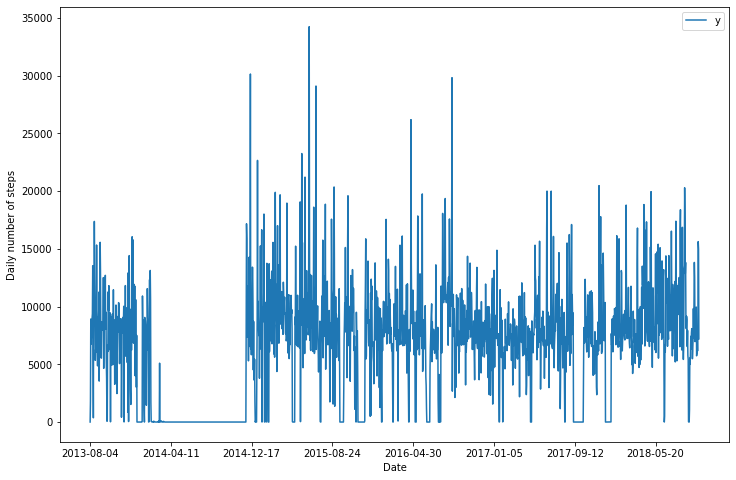

In [7]:
# Plot steps vs time dataframe
ax = steps_df.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Daily number of steps')
ax.set_xlabel('Date')
plt.show()

So this pattern does seem to confirm the insights we just obtained from our descriptive stats, though we also note a gap in observations around 2014.

Yet we can also note how highly variable and unstructured the data is. This could prove really challenging to analyse as well as model for future predictions.

Let us now create our time series model with Prophet.

In [8]:
# Initialise model
steps_model = Prophet()
# Fit model to data (syntax much like sklearn)
steps_model.fit(steps_df)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


For forcasting with Prophet, we need to generate a series of date intervals for the model to generate predictions for. We will generate a series of daily date intervals, for the coming year.

In [9]:
# Generate future date intervals for predictions
future_steps = steps_model.make_future_dataframe(periods=365)
# Show last few rows
future_steps.tail()

,ds
2245,2019-09-27
2246,2019-09-28
2247,2019-09-29
2248,2019-09-30
2249,2019-10-01


We can now use our future data intervals with the model to generate our forcast & predictions.

In [10]:
# Generate forcast for steps
steps_forecast = steps_model.predict(future_steps)
# Print key columns of forcast, last few rows
steps_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2245,2019-09-27,10295.368852,4492.369615,16250.247709
2246,2019-09-28,11327.901630,5626.959941,16948.631875
2247,2019-09-29,10430.306519,4517.091316,16719.706493
2248,2019-09-30,10110.778399,4486.686990,16102.935634
2249,2019-10-01,10301.479747,4156.269868,16019.505811


As well as the main prediction column yhat, we also get columns for the upper and lower bounds of the confidence interval yhat_upper & yhat_lower respectively.

Lets now plot the forcast, so this will be all our previous data observations plus our forcast data for 1 year ahead.

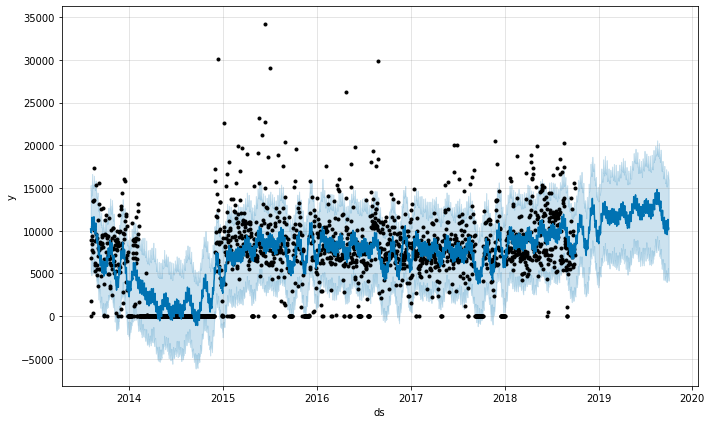

In [11]:
# Plot data + forcast
fig1 = steps_model.plot(steps_forecast)

So the original data points are in black, forcast dark blue and confidence interval light blue. We can see the model predicting an encouraging increase in my step count for the coming year.

Before we look more into what the model is forcasting though, we need to first know - how good is this model at fitting to the data? 

Prophet includes functionality for time series cross validation to measure forecast error using historical data. This is done by selecting cutoff points in the history, and for each of them fitting the model using data only up to that cutoff point. We can then compare the forecasted values to the actual values.

So we will now apply cross validation to our model.

In [12]:
# Apply cross validation
# Note: Here we do cross-validation to assess prediction performance on a horizon of 365 days, starting with 1095 days/3 years of training data in the first 
# cutoff and then making predictions every 90 days. On our 5 year time series, this corresponds to 5 total forecasts.
steps_cv_df = cross_validation(steps_model, initial='1095 days', period='90 days', horizon = '365 days')
steps_cv_df.head()

INFO:fbprophet:Making 5 forecasts with cutoffs between 2016-10-06 00:00:00 and 2017-10-01 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2016-10-07,7617.168202,2614.212801,12439.613701,9041,2016-10-06
1,2016-10-08,8686.498257,3751.377013,13098.352508,7533,2016-10-06
2,2016-10-09,7418.058319,2637.630912,12436.221907,3215,2016-10-06
3,2016-10-10,7433.763618,2538.258780,12666.030680,8950,2016-10-06
4,2016-10-11,7898.809182,2746.013188,12742.630456,6043,2016-10-06


We can then use the performance metrics module from Prophet to calculate some regression type metrics for performance.



In [13]:
# Calculate performance metrics
steps_metrics_df = performance_metrics(steps_cv_df)
# Plot first few rows
steps_metrics_df.head()

INFO:fbprophet:Skipping MAPE because y close to 0


,horizon,mse,rmse,mae,mdape,coverage
0,37 days,1.085889e+07,3295.283147,2520.033727,0.253464,0.838462
1,38 days,1.142094e+07,3379.487961,2568.009727,0.253464,0.832967
2,39 days,1.146723e+07,3386.329553,2577.043225,0.260470,0.829670
3,40 days,1.185263e+07,3442.764615,2604.417994,0.260470,0.827473
4,41 days,1.187337e+07,3445.775950,2604.376144,0.261819,0.830769


In [14]:
# Plot last few rows
steps_metrics_df.tail()

,horizon,mse,rmse,mae,mdape,coverage
324,361 days,2.877255e+07,5364.004952,4245.635281,0.406386,0.640659
325,362 days,2.881445e+07,5367.909644,4283.076512,0.418145,0.638462
326,363 days,2.942481e+07,5424.464457,4341.394789,0.419155,0.629670
327,364 days,3.012010e+07,5488.177793,4383.801476,0.419155,0.624176
328,365 days,3.025307e+07,5500.278635,4401.557091,0.419155,0.624176


So the metrics indicate that unfortunately the model does very poorly in terms of accuracy, for example the root mean squared error (rmse) is in the region of 3000! We knew from earlier that this data had very high variability and perhaps little structure, and so we can see how challenging this has made making accurate predictions.

We can also plot rmse against the data points from the horizon to see the challenge of what it is trying to fit.

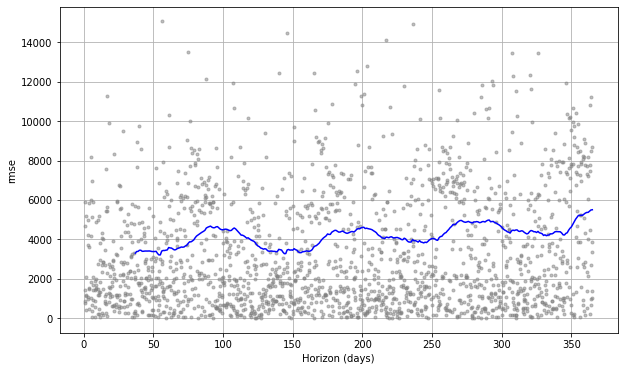

In [15]:
# Plot rmse against validation horizon data
fig3 = plot_cross_validation_metric(steps_cv_df, metric='rmse')

Plotting the validation data as points, seeing how highly unstructured and variable it is - really illustrates what a difficult job it really is to fit any kind of model to this data. So unfortunately, for this steps model we have to have a big caveat over any results and predictions this model makes due to its poor performance.

With those caveats made, Prophet also allows us to easily plot forcast components whch include: 

- Trend
- Weekly seasonality
- Yearly seasonality

So lets now plot these.

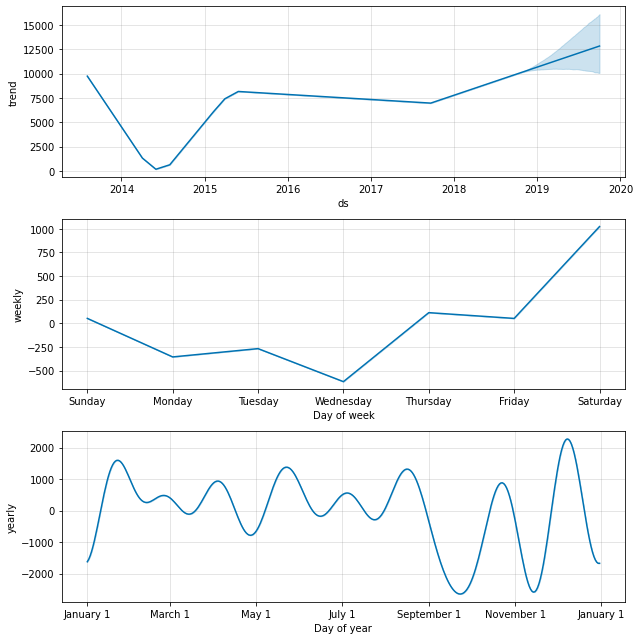

In [16]:
# Plot forcast components
fig2 = steps_model.plot_components(steps_forecast)

For the overally trend, bar the missing values we know about in 2014/15 - we can observe that there does seem to have been a slight, gradual decline in my steps for the years between 2013-2017. However there has also been a notable and consistant increase from late 2017 to 2018, and the forcast including most of the confidence interval, projects an ongoing increase in my step counts.

For the weekly seasonality, it highlights Saturday as the day on which I get the most steps in. From my own anacdotal observations, this is not entirely surprising - this really tends to be the day when I have time to get more walking in. What is more surprising to me is the worst day for steps, which apparently is Wednesday. I am not exactly sure why, however a simple thing I could choose to do might be to walk a little more on Wednesday, this would not only improve my total steps over the week, but would improve my baseline activity level for my health overall.

For yearly seasonality between say March-September I seem to have a level of activity that seems to have less variability, whereas during the months October-Feburary, there is much higher variability and extreme values for my steps. Using my domain knowledge, I would speculate that maybe during the summer months, I am more consistantly active outdoors, whereas in the colder winter months, I seem to oscilate between periods of extreme inactivity perhaps compensated by periods of very high activity - such as long country winter walks!.

However given the poor performance of the model in our cross validation evaluation, we must treat these indications with exteme skepticism.

## 6. Time series analysis of sleep

Let us now do our analysis of the sleep.

In [17]:
# Convert sleep duration from milliseconds to hours
df['duration_hours'] = ((df['Duration'] / 1000) / 60) / 60
df.head()

,Steps,Date,Awake Count,Awake Duration,Awakenings Count,Duration,Efficiency,Sleep Start Time,Sleep End Time,Minutes After Wakeup,Minutes Asleep,Minutes Awake,Minutes to fall asleep,Restless Count,Restless Duration,Time in Bed,duration_hours
0,0,2013-08-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1822,2013-08-05,3.0,22.0,22.0,35340000.0,94.0,2013-08-05T22:11:00.000,2013-08-06T08:00:00.000,0.0,508.0,33.0,48.0,19.0,61.0,589.0,9.816667
2,8920,2013-08-06,1.0,4.0,19.0,25620000.0,91.0,2013-08-07T00:53:00.000,2013-08-07T08:00:00.000,0.0,329.0,33.0,65.0,18.0,94.0,427.0,7.116667
3,6751,2013-08-07,3.0,3.0,13.0,32520000.0,93.0,2013-08-07T22:58:00.000,2013-08-08T08:00:00.000,1.0,395.0,32.0,114.0,10.0,129.0,542.0,9.033333
4,7687,2013-08-08,3.0,8.0,17.0,29400000.0,95.0,2013-08-08T23:50:00.000,2013-08-09T08:00:00.000,0.0,453.0,26.0,11.0,14.0,29.0,490.0,8.166667


In [18]:
# Extract columns of interest
sleep_df = df[['Date', 'duration_hours']]
# Rename columns for Prophet
sleep_df = sleep_df.rename(columns={'Date': 'ds', 'duration_hours': 'y'})
# Print first few rows
sleep_df.head()

,ds,y
0,2013-08-04,NaN
1,2013-08-05,9.816667
2,2013-08-06,7.116667
3,2013-08-07,9.033333
4,2013-08-08,8.166667


In [19]:
# Lets plot some key descriptive stats for sleep hours
sleep_df.describe()

,y
count,1342.000000
mean,7.781172
std,1.749559
min,1.000000
25%,6.916667
50%,7.800000
75%,8.700000
max,16.100000


So these key stats give us some idea of what is going on with the sleep hours data. We can see that the mean and median are are very close at around 7.7-7.8 terms of the mid range. We can see the std dev is at 1.74 indicating much lower variability than our steps.

In terms of outliers, we can see they range from 0 to 16.1 on my best day of sleep. Being a domain expert on my sleep and I can confirm that these do seem like reasonable values for each of these key stats (the 16 hours sleep day legitimately did happen once, but won't be elaborated on for this study!).

Lets now plot these raw sleep values over time.

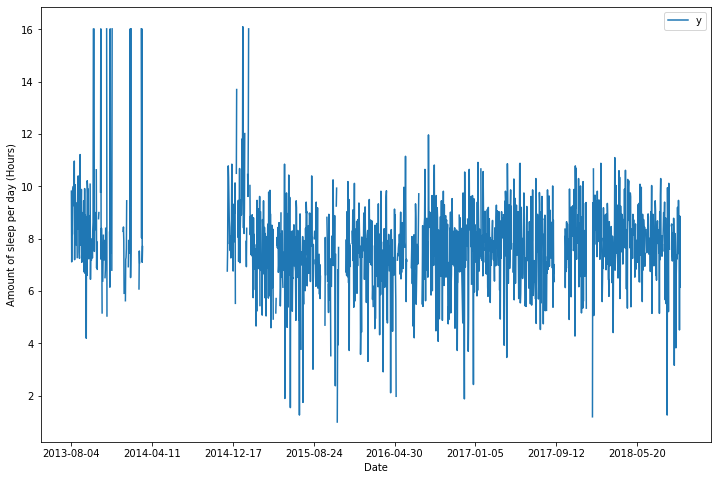

In [20]:
# Plot raw sleep hours values
ax = sleep_df.set_index('ds').plot(figsize=(12, 8))
ax.set_ylabel('Amount of sleep per day (Hours)')
ax.set_xlabel('Date')
plt.show()

So this pattern does seem to confirm the insights we just obtained from our descriptive stats, though we also note a gap in observations around 2014. Less variability than we found with steps, and the suggestions of some periodic patterns over time.

We now create our time series model with Prophet.

In [21]:
# Create Prophet sleep model
sleep_model = Prophet()
sleep_model.fit(sleep_df)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [22]:
# Generate future date intervals for predictions
future_sleep = sleep_model.make_future_dataframe(periods=365)
# Show last few rows
future_sleep.tail()

,ds
2245,2019-09-27
2246,2019-09-28
2247,2019-09-29
2248,2019-09-30
2249,2019-10-01


In [23]:
# Generate forcast for sleep
sleep_forecast = sleep_model.predict(future_sleep)
# Print key columns of forcast, last few rows
sleep_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
2245,2019-09-27,7.771730,5.620440,9.842986
2246,2019-09-28,8.114271,6.019974,10.219169
2247,2019-09-29,8.038204,5.981808,10.071523
2248,2019-09-30,8.342145,6.151609,10.440700
2249,2019-10-01,8.099455,5.994919,10.165463


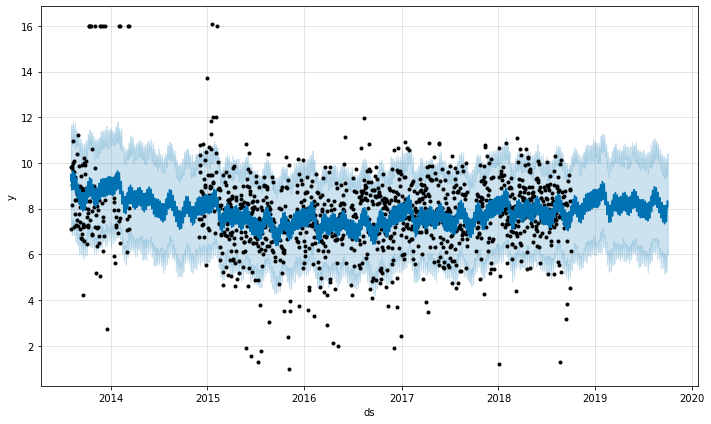

In [24]:
# Plot data and forcast
fig1 = sleep_model.plot(sleep_forecast)

So as a reminder - the original data points are in black, forcast dark blue and confidence interval light blue. 

Again, before we go further into the details of the models forcasts, we should really evaluate our model to ensure how well or not it is making good predictions. So we will now apply cross validation.

In [26]:
# Apply cross validation
# Note: Here we do cross-validation to assess prediction performance on a horizon of 365 days, starting with 1095 days/3 years of training data in the first 
# cutoff and then making predictions every 90 days. On our 5 year time series, this corresponds to 5 total forecasts.
sleep_cv_df = cross_validation(sleep_model, initial='1095 days', period='90 days', horizon = '365 days')
sleep_cv_df.head()

INFO:fbprophet:Making 5 forecasts with cutoffs between 2016-10-05 00:00:00 and 2017-09-30 00:00:00


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2016-10-06,7.663664,5.434498,9.976815,6.533333,2016-10-05
1,2016-10-07,7.888469,5.496584,10.190964,8.633333,2016-10-05
2,2016-10-08,8.484493,6.195318,10.779478,8.716667,2016-10-05
3,2016-10-09,8.207862,5.719192,10.519898,6.950000,2016-10-05
4,2016-10-10,8.729057,6.361155,11.174465,8.250000,2016-10-05


We can then use the performance metrics module from Prophet to calculate some regression type metrics for performance.

In [27]:
# Calculate performance metrics
sleep_metrics_df = performance_metrics(sleep_cv_df)
# Plot first few rows
sleep_metrics_df.head()

,horizon,mse,rmse,mae,mape,mdape,coverage
0,35 days,2.392069,1.546632,1.199436,0.171015,0.116884,0.846154
1,36 days,2.455044,1.566858,1.218402,0.176400,0.123101,0.841346
2,37 days,2.451293,1.565661,1.214792,0.175659,0.116884,0.839744
3,38 days,2.520865,1.587723,1.243524,0.180894,0.129761,0.838141
4,39 days,2.550738,1.597103,1.260578,0.182533,0.130406,0.833333


In [28]:
# Plot last few rows
sleep_metrics_df.tail()

,horizon,mse,rmse,mae,mape,mdape,coverage
326,361 days,2.154585,1.467850,1.077806,0.187337,0.101232,0.903846
327,362 days,2.120549,1.456210,1.064399,0.185658,0.100815,0.907692
328,363 days,2.144089,1.464271,1.068619,0.188077,0.100815,0.905128
329,364 days,2.410376,1.552539,1.091549,0.222418,0.100285,0.903846
330,365 days,2.415177,1.554084,1.094597,0.222573,0.100285,0.903846


So we can see that this sleep model is doing far better than our steps model at predictions, with an rmse of 1.54 or mean absolute percentage error (mape) of around 17% for 35 days. For a longer forcast approaching a year/365 days this only increases slightly to around 22% for mape and literally only that jump on the 364th day. So a relatively stable error rate for forcasts of up to a year of around 17/18% mape.

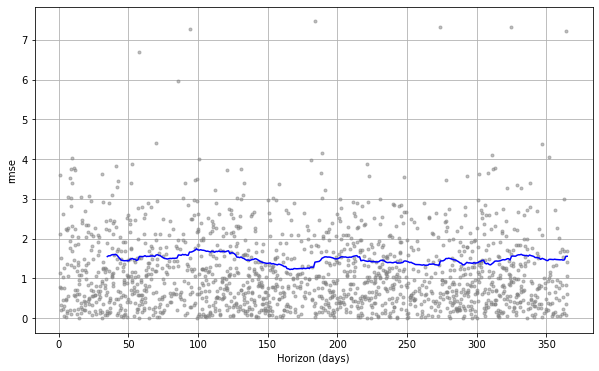

In [29]:
# Plot rmse against validation horizon data
fig3 = plot_cross_validation_metric(sleep_cv_df, metric='rmse')

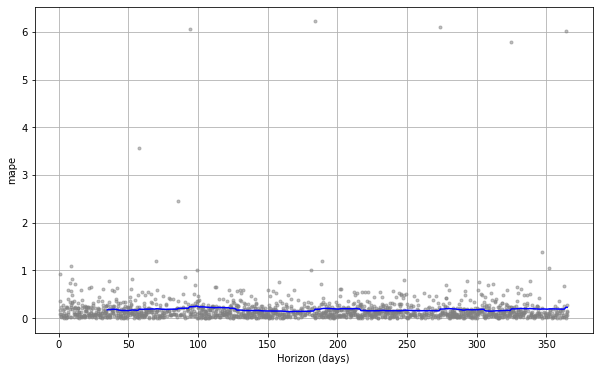

In [31]:
# Plot mape against validation horizon data
fig4 = plot_cross_validation_metric(sleep_cv_df, metric='mape')

Let's now plot the forcast components.

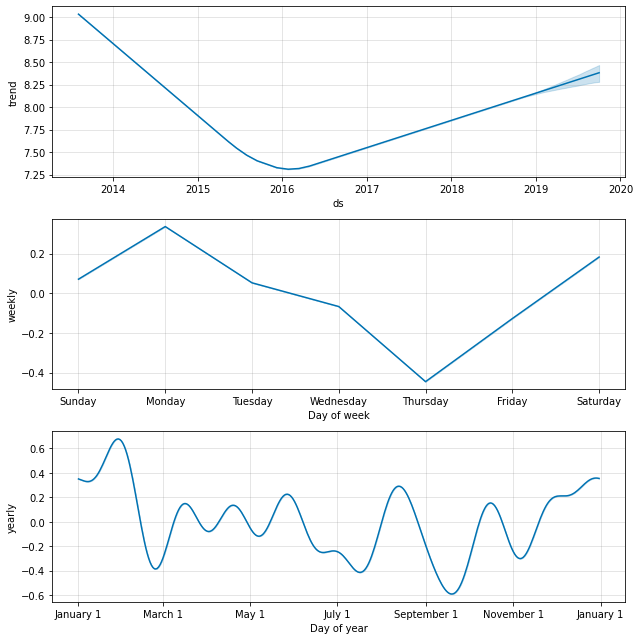

In [32]:
# Plot forcast components
fig2 = sleep_model.plot_components(sleep_forecast)

So for overall trend, it seems that my sleep has been getting worse from 2013-2016 - but from 2016-2018 it seems to have been steadily improving, and is projected to do so going forwards in the forcast. Note the forcast also has quite a narrow confidence interval, all of which also indicates and increase in sleep. So we could have a good indication here that my sleep is getting better!

For weekly seasonality, the model suggests that Monday is my best day for sleep and Thursday is my worst. I cannot think of an obvious reason as to why, but that is very interesting to note for me.

For yearly seasonality, we can note perhaps a similar pattern to that of steps: less variability during the summer months from March-September, and more variability in the months October-Feburary. I wonder is there a connection to steps & activity? or to the seasons of summer & winter & temperature perhaps? Questions that perhaps could be explored in another study.

Given the better performance of this model in cross validation, we can have more confidence in these indications that those for our steps model.

## 7. Conclusion

So to summarise my findings:

#### Steps
We found that the model performed very poorly on validation of its forcasts (i.e. a rmse of 3000+). This is perhaps in large part, to the step data being highly variable and lacking much structure or pattern of any sort. With that caveat, there were some hints of the following:
- That my steps have been decreasingly slightly from 2013-2017 and then increasing from 2018 onwards
- Saturdays seem to be my best day and Wednesday is my worst day for steps
- I seem more consistant with taking more steps in the summer months from March-September and more variable in the winter months from October-Feburary

#### Sleep
We found the model acheived a MAPE error in it's forcasts of between 17-22% for periods of around a month to a year respectively on validation. There were also indications of the following:
- That my sleep had been getting worse from 2013-2016, then improving from 2016-2018 onwards
- Mondays seem to be my best day for sleep, and Thursdays my worst day
- I seem to get more consistant and better sleep in the summer months from March-September and more variable sleep in the winter months from October-Feburary

The Prophet library itself was very easy and quick to use with its default setup, especially in terms of building a model, evaluating the model, and displaying the results of both of these key processes in a way that was easy and intuitive to understand. The further configuration options are something that could be explored further to enable more fine tuning of the model and to customise it to a specific use-case.